# Hello Reuters Newswires Multiclass Classifier

Reuters dataset with newswires categorized into 46 different topics

In [1]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers

### Get data from Reuters Dataset

In [2]:
from tensorflow.keras.datasets import reuters

# Load the dataset
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

```num_words=10000``` means to only keep the top 10,000 most frequently occurring words in the training data. Discard rare words to keep size manageable.

In [3]:
print(f"training data size: {train_data.shape}, test data size {test_data.shape}")

training data size: (8982,), test data size (2246,)


Decode newswires back to text

In [4]:
word_index = reuters.get_word_index()    # Dictionary mapping
# Reverse the index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# indices are offset by 3 to words as 0, 1, and 2 are reserved indices for “padding,”
# “start of sequence,” and “unknown.”
decoded_newswire_0 = " ".join([reverse_word_index.get(i-3,"?") for i in train_data[0]])
print("First review: ", decoded_newswire_0)

First review:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Prepare Data

Multi-Hot Encode the reviews to 10,000-dimensional vectors

In [5]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.

    return results

In [6]:
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [10]:
print(f"Training data shape: {X_train.shape}, test data shape {X_test.shape}")

Training data shape: (8982, 10000), test data shape (2246, 10000)


One-hot Encode labels (46 classes)

In [7]:
def one_hot_encode(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    
    return results

In [8]:
y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)

In [11]:
print(f"Training labels shape: {y_train.shape}, test labels shape {y_test.shape}")

Training labels shape: (8982, 46), test labels shape (2246, 46)


Keras has functions to do the same

In [9]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(train_labels)
#y_test = to_categorical(test_labels)

### Build the ANN Model with Keras

In [12]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

# Compile
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

### Validate model

Extract samples for validation set

In [14]:
# Use 1,000 samples from training data for validation
X_val = X_train[:1000]
X_train_partial = X_train[1000:]
y_val = y_train[:1000]
y_train_partial = y_train[1000:]

Fit the model

In [15]:

history = model.fit(X_train_partial, y_train_partial,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4166 - loss: 3.1011 - val_accuracy: 0.6300 - val_loss: 1.7657
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6652 - loss: 1.6031 - val_accuracy: 0.6890 - val_loss: 1.3428
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7403 - loss: 1.2019 - val_accuracy: 0.7410 - val_loss: 1.1453
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7971 - loss: 0.9746 - val_accuracy: 0.7740 - val_loss: 1.0354
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8271 - loss: 0.7913 - val_accuracy: 0.7820 - val_loss: 0.9758
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8575 - loss: 0.6510 - val_accuracy: 0.8020 - val_loss: 0.9134
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8829 - loss: 0.5529 - val_accuracy: 0.8100 - val_loss: 0.8865
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9062 - loss: 0.4453 - val_accuracy: 0.8160 - v

Plot training and validation history

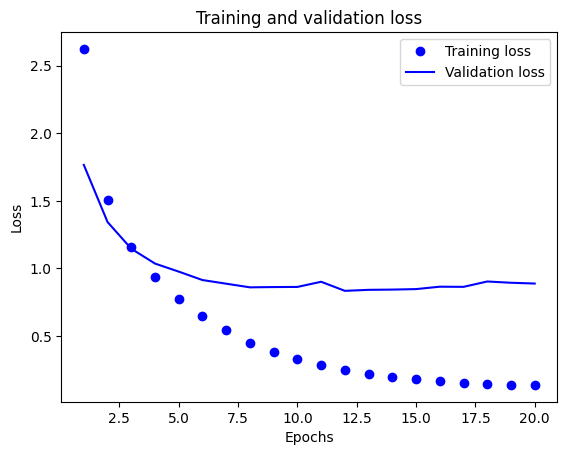

In [16]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

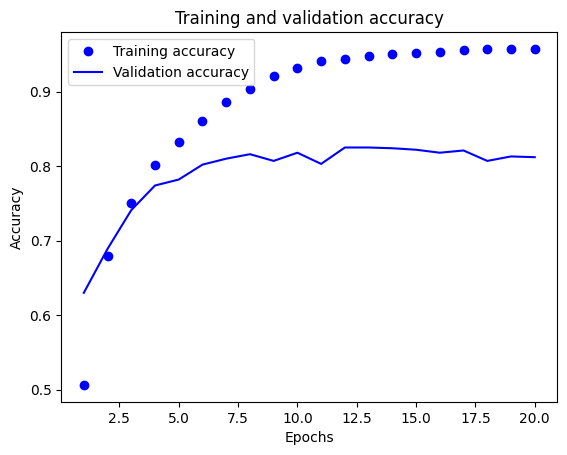

In [17]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Model begins overfitting at 9 epochs

### Train with full training set and evaluate with test set

In [18]:
# Model
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

# Compile
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# Train
model.fit(X_train, y_train, epochs=9, batch_size=512)


results = model.evaluate(X_test, y_test)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4217 - loss: 3.0009
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6708 - loss: 1.5174
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7494 - loss: 1.1393
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8039 - loss: 0.9203
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8359 - loss: 0.7454
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8636 - loss: 0.6293
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8900 - loss: 0.5169
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9115 - loss: 0.4292
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9209 - loss: 0.3713
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7975 - loss: 0.8894


In [19]:
print(f"Test loss: {results[0]:.3f}, test accuracy: {results[1]:.3f}")

Test loss: 0.916, test accuracy: 0.789


80% accuracy for 46 classes, what would be a baseline with accuracy for random classifier?

In [21]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits = (np.array(test_labels) == np.array(test_labels_copy))
print(np.mean(hits))


0.17497773820124665


Random baseline would be ~17-18%

### Predictions

In [22]:
predictions = model.predict(X_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [26]:
print("Predictions shape: ", predictions.shape)
print("Prediction sum: ", np.sum(predictions[0]))
# Most common category
print("Prediction for newswire 0", predictions[0])
print("Most likely category: ", np.argmax(predictions[0]))

Predictions shape:  (2246, 46)
Prediction sum:  1.0
Prediction for newswire 0 [1.1710822e-04 4.5678005e-04 1.3132321e-04 8.3373874e-01 1.5071066e-01
 1.7192557e-05 1.7877932e-04 1.6341924e-04 3.0825203e-03 2.6034951e-04
 4.7552655e-04 5.2028522e-04 5.0467992e-04 4.7191238e-04 2.7447593e-05
 1.4822163e-04 1.5323026e-03 2.1271266e-04 1.6260215e-04 1.2521070e-03
 1.9372926e-03 4.0177369e-04 2.3451370e-05 3.1322640e-04 1.3059708e-04
 5.3676831e-05 5.3673146e-05 2.6874208e-05 1.7247167e-04 6.8799907e-04
 2.5509155e-05 1.6477527e-04 6.2413237e-05 3.8179023e-05 2.3839721e-05
 1.5665828e-05 8.7389268e-04 7.9776837e-05 3.5759411e-05 8.3748404e-05
 7.4728872e-05 1.9635051e-04 2.4031648e-05 1.7663548e-04 4.2148008e-06
 1.5481879e-04]
Most likely category:  3
